# Cereal ratings: 3 top variables
Data Analysis Python Pandas Model Linear Regression Data Manipulation Data Visualization External Dataset

Suppose you have the following [dataset](https://docs.google.com/spreadsheets/d/1OyFwsZ77RnGiwSSkTPx6j9V9qyOqitysQij4WW4nhMU/edit?usp=sharing), 
which is a list of 80 cereals, containing the following fields:

```
    mfr: Manufacturer of cereal
        A = American Home Food Products
        G = General Mills
        K = Kelloggs
        N = Nabisco
        P = Post
        Q = Quaker Oats
        R = Ralston Purina
    type:
        cold
        hot
    calories: calories per serving
    protein: grams of protein per serving
    fat: grams of fat per serving
    sodium: milligrams of sodium
    fiber: grams of dietary fiber
    carbs: grams of complex carbohydrates
    sugars: grams of sugars
    potass: milligrams of potassium
    vitamins: vitamins and minerals - 0, 25, or 100, indicating the typical percentage of FDA recommended
    shelf: display shelf (1, 2, or 3, counting from the floor)
    weight: weight in ounces of one serving
    cups: number of cups in one serving
    rating: a rating of the cereals (Possibly from Consumer Reports?)
```

Using this data, can you determine the best 3 independent variables that help determine cereal rating?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline

filename = 'q164_data_cereals.csv'
df = pd.read_csv(filename)
print('shape', df.shape)
print(df.columns)
df.head()

shape (77, 16)
Index(['name', 'mfr', 'type', 'calories', 'protein', 'fat', 'sodium', 'fiber',
       'carbs', 'sugars', 'potass', 'vitamins', 'shelf', 'weight', 'cups',
       'rating'],
      dtype='object')


,name,mfr,type,calories,protein,fat,sodium,fiber,carbs,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


In [2]:

def normalize_columns(df, cols):
    """ normalize the provided columns: mean 0, sd 1 """
    ddf = df.copy()
    for col in cols:
        ddf[col] = (ddf[col] - ddf[col].mean()) / ddf[col].std()
    return ddf


def prep_data(df):
    """ prepare the data 
    return dataframe, label:str, numerical_features:list<str>, categorical_features:list<str>

    """
    ddf = df.copy()
    
    numerical_features = [
        'calories','protein','fat','sodium',
        'fiber','carbs','sugars','potass','vitamins',
        'weight','cups'
    ]
    categorical_features = []
    label = 'rating'
    
    # add random for baseline importance
    ddf['random'] = np.random.random(size = len(ddf))
    numerical_features.append('random')
    
    # add is_cold
    ddf['is_cold'] = (ddf['type'] == 'C').astype(int)
    categorical_features.append('is_cold')
    
    # dummy-code mfr as mfr_x, mfr_y, etc
    mfr_dummies_df = pd.get_dummies(ddf['mfr'], prefix='mfr')
    mfr_dummies_df.columns = [c.lower() for c in mfr_dummies_df.columns]
    ddf = pd.concat([ddf, mfr_dummies_df], axis=1)
    categorical_features += list(mfr_dummies_df.columns)
    
    ddf = ddf[numerical_features + categorical_features + [label]].dropna()
    ddf = normalize_columns(ddf, numerical_features)
    return ddf, label, numerical_features, categorical_features


clean_df,label, numerical_features, categorical_features = prep_data(df)
clean_df.head()

,calories,protein,fat,sodium,fiber,carbs,sugars,potass,vitamins,weight,...,random,is_cold,mfr_a,mfr_g,mfr_k,mfr_n,mfr_p,mfr_q,mfr_r,rating
0,-1.892984,1.328607,-0.012903,-0.353984,3.292847,-2.242931,-0.207447,2.580029,-0.145317,-0.196777,...,-0.836684,1,0,0,0,1,0,0,0,68.402973
1,0.673209,0.415190,3.961373,-1.725771,-0.063754,-1.541825,0.242508,0.545993,-1.264260,-0.196777,...,-0.221789,1,0,0,0,0,0,1,0,33.983679
2,-1.892984,1.328607,-0.012903,1.196731,2.873272,-1.775527,-0.432425,3.141143,-0.145317,-0.196777,...,0.128464,1,0,0,1,0,0,0,0,59.425505
3,-2.919461,1.328607,-1.006473,-0.234699,4.971147,-1.541825,-1.557313,3.281421,-0.145317,-0.196777,...,-1.325509,1,0,0,1,0,0,0,0,93.704912
4,0.159970,-0.498228,0.980666,0.481016,-0.483329,-0.139614,0.242508,-1.361794,-0.145317,-0.196777,...,0.874879,1,0,0,0,0,0,0,1,34.384843


r2 train: 0.97 
r2 oob: 0.80 
r2 valid: 0.48
          importance
name                
sugars      0.650743
calories    0.188856
carbs       0.034050
sodium      0.032650
random      0.030029
fat         0.013103
mfr_n       0.010975
cups        0.010419
vitamins    0.007201
potass      0.007179
fiber       0.006465
protein     0.002887
mfr_p       0.002453
is_cold     0.001087
mfr_k       0.000692
mfr_q       0.000583
weight      0.000514
mfr_g       0.000115
mfr_a       0.000000
mfr_r       0.000000


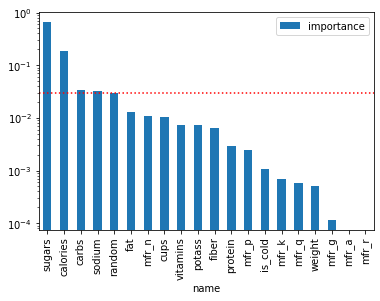

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


def prep_train_valid_sets(df, label, column_blacklist=[], seed=123):
    """
    Return train and validation sets
    Plot feature importance in barplot
    """
    # ignore columns in blacklist
    features = [col for col in df.columns if col != label and col not in column_blacklist]
    
    # split
    x_train, x_valid, y_train, y_valid = train_test_split(
        df[features], 
        df[label], 
        test_size = 0.8, 
        random_state = seed
    )
    return x_train, x_valid, y_train, y_valid


def train_rf(x_train, y_train, n_trees=200, seed=123):
    """ Return a random forest regressor of y ~ x """
    rf = RandomForestRegressor(
        n_estimators = n_trees,
        n_jobs = -1,
        oob_score = True,
        bootstrap = True,
        random_state = seed
    )
    rf.fit(x_train, y_train)
    return rf
    
    
def compute_rf_perf_and_importance(rf, x_train, y_train, x_valid, y_valid):
    """
    Given a random forest model, compute R2 and feature importances.
    Return:
    - model performance: r-square on train, on OOB during training, and on validation.
    - df mapping each feature name to its importance in [0,1]
    """
    # https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
    # https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    
    # performance scores
    r2_train = rf.score(x_train, y_train)
    r2_oob = rf.oob_score_
    r2_valid = rf.score(x_valid, y_valid)
    
    # feature importance
    importance_df = (
        pd.DataFrame({
            'name': list(x_train.columns),
            'importance': rf.feature_importances_
        })
        .set_index('name')
        .sort_values('importance', ascending=False)
    )
    
    return r2_train, r2_oob, r2_valid, importance_df


def display_perf_importance(r2_train, r2_oob, r2_valid, importance_df):
    """ Given performance of a model,
    and feature importance df,
    plot importance as barplot,
    and simply print importance_df.
    Return nothing
    """
    print(f"r2 train: {r2_train:.2f} \nr2 oob: {r2_oob:.2f} \nr2 valid: {r2_valid:.2f}")
    ax = importance_df.plot(kind='bar')
    ax.set(yscale='log')
    plt.axhline(y=importance_df.loc['random'][0], color='r', linestyle='dotted')
    print(importance_df)

    
# let's finally get and plot importances
def get_factor_importance(bdf, label, column_blacklist=[]):
    """ Wrap all functions above together.
    given a beer df and continuous label, train a regression forest, 
    print its performance, return nothing.
    """
    x_train, x_valid, y_train, y_valid = prep_train_valid_sets(bdf, label)
    rf = train_rf(x_train, y_train)
    r2_train, r2_oob, r2_valid, importance_df = compute_rf_perf_and_importance(rf, x_train, y_train, x_valid, y_valid)
    display_perf_importance(r2_train, r2_oob, r2_valid, importance_df)
    
get_factor_importance(clean_df, label)


# Conclusion

Only 2 features predict ratings better than random: sugars, and calories.
